In [1]:
import networkx as nx
from cgsmiles import read_cgsmiles
import itertools
import numpy as np
from collections import Counter, defaultdict
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import pysmiles
import cgsmiles

In [2]:
def read_inter_matrix(datafile="levels.dat"):
    with open(datafile, 'r') as _file:
        lines = _file.readlines()
        level_dict = {}
        col_labels = lines[0].strip().split() 
        bead_to_index = dict(zip(col_labels, np.arange(0, len(col_labels))))
        for line in lines[1:]:
            tokens = line.strip().split()
            row_type = tokens[-1]
            for idx, token in enumerate(tokens[:-1]):
                level_dict[frozenset([row_type, col_labels[idx]])] = int(token)
    return level_dict, bead_to_index

def read_mol_strings(datafile='mols.dat'):
    mol_strings = {}
    with open(datafile, 'r') as _file:
        lines = _file.readlines()
    for line in lines:
        tokens = line.strip().split()
        mol_strings[tokens[0]] = tokens[1]
    return mol_strings

def modify_level(level, ba, bb, alA, alB, dlA, dlB, rlA, rlB, hlA, hlB):
    
    if ba == 'W' and (alB or dlB):
        level += 1
        
    if bb == 'W' and (alA or dlA):
        level += 1
    
    if alA and alB:
        level += 1
            
    if dlA and dlB:
        level += 1
        
    if (alA and dlB) or (dlA and alB):
        level -= 1
            
    if rlA and rlB:
        level += 1
            
    if hlA and hlB:
        level -= 1
            
    return level


def generate_feature_vector(mol_str_a, mol_str_b, bead_matrix, bead_to_index, polyA=False, polyB=False):
    """
    Generate the graph of a Martini molecule and
    assing bead types.
    """
    feat_level_matrix_W = np.zeros((19, 6),dtype=float)
    feat_level_matrix_SOL = np.zeros((19, 6),dtype=float)
    feat_bead_count_vector = np.zeros((1), dtype=float)
    size_to_plane = {frozenset((0, 0)): 0,
                     frozenset((1, 1)): 1,
                     frozenset((2, 2)): 2,
                     frozenset((0, 1)): 3,
                     frozenset((0, 2)): 4,
                     frozenset((1, 2)): 5,}

    #mol_a = read_cgsmiles(mol_str_a)
    mol_a, aa_mol = cgsmiles.MoleculeResolver.from_string(mol_str_a).resolve_all()
    smiles_str = pysmiles.write_smiles(aa_mol)
   # print(smiles_str)
    mol = Chem.AddHs(Chem.MolFromSmiles(smiles_str))
    AllChem.EmbedMolecule(mol)
    vol = AllChem.ComputeMolVolume(mol)
    
    mol_b = read_cgsmiles(mol_str_b)
   # print(mol_str_a, mol_str_b)
    mol_a_types = list(nx.get_node_attributes(mol_a, "fragname").values())
    mol_b_types = list(nx.get_node_attributes(mol_b, "fragname").values())
    feat_bead_count_vector = vol #len(mol_a_types)
    #print(mol_a_types)
   # print(mol_b_types)
    inter_graphs = []
    for mol in [mol_a_types, mol_b_types, ['W']]:
       # print(mol)
        inter_graph = nx.Graph()
        idx = 0
        #bead_counts = Counter(mol)
        #Efor bead, num in bead_counts.items():
        for bead in mol:
            if bead[0] == "T":
                size = 0
                bead = bead[1:]
            elif bead[0] == "S":
                size = 1
                bead = bead[1:]
            else:
                size = 2 
                        
            al = False
            dl = False
            hl = False
            rl = False
            el = False
            vl = False
            
            if bead[-1].isupper() and bead[-1] != 'W':
                bead = bead[:-1]
            
            if bead[-1] == "r":
                rl = True
                bead = bead[:-1]
            
            if bead[-1] == "h":
                hl = True
                bead = bead[:-1]
            
            if bead[-1] == 'e':
                el = True
                bead = bead[:-1]
            
            if bead[-1] == 'v':
                vl = True
                bead = bead[:-1]
        
            if bead[-1] == "a":
                al = True
                bead = bead[:-1]

            if bead[-1] == "d":
                dl = True
                bead = bead[:-1]

        
            bead_index = bead_to_index[bead]        
            inter_graph.add_node(idx, size=size, bead_type=bead, alabel=al, dlabel=dl, rlabel=rl, hlabel=hl)
            idx += 1
        inter_graphs.append(inter_graph)
    #print(len(inter_graphs))
   # print(inter_graphs[0].nodes(data=True))
        
    # combinations of W with solute
    # combinations of solvent and solute
    bead_combos = []
    counter = 0
    for inter_graph_a, inter_graph_b in [(inter_graphs[0],inter_graphs[1]), (inter_graphs[0], inter_graphs[2])]:
       # print(inter_graph_a.nodes(data=True))
       # print(inter_graph_b.nodes(data=True))
       # print("\n")
        bead_combos = itertools.product(inter_graph_a.nodes, inter_graph_b.nodes)
        #print(list(bead_combos))
        bead_combos = itertools.product(inter_graph_a.nodes, inter_graph_b.nodes)
        for ba, bb in bead_combos:
            bead_a = inter_graph_a.nodes[ba]['bead_type']
            bead_b = inter_graph_b.nodes[bb]['bead_type']
            level = bead_matrix[frozenset([bead_a, bead_b])]
            #print(bead_a, bead_b, level)
            level = modify_level(level=level,
                                 ba=bead_a,
                                 bb=bead_b,
                                 alA=inter_graph_a.nodes[ba]['alabel'], 
                                 alB=inter_graph_b.nodes[bb]['alabel'], 
                                 dlA=inter_graph_a.nodes[ba]['dlabel'], 
                                 dlB=inter_graph_b.nodes[bb]['dlabel'], 
                                 rlA=inter_graph_a.nodes[ba]['rlabel'], 
                                 rlB=inter_graph_b.nodes[bb]['rlabel'], 
                                 hlA=inter_graph_a.nodes[ba]['hlabel'], 
                                 hlB=inter_graph_b.nodes[bb]['hlabel'],)
            #print(bead_a, bead_b, level)
            third_dimension = size_to_plane[frozenset([inter_graph_a.nodes[ba]['size'], 
                                                       inter_graph_b.nodes[bb]['size']])]
        
            if counter == 0:
                feat_level_matrix_SOL[level-1, third_dimension] += 1
            else:
                feat_level_matrix_W[level-1, third_dimension] += 1

        counter += 1
       # if polyA:
       #     feat_bead_count_vector[-2] = 1
       # if polyB:
       #     feat_bead_count_vector[-1] = 1
            
        
            
    #feat_level_matrix = np.sum(feat_level_matrix, axis=2)
   # print(feat_level_matrix.shape)
    #print(feat_level_matrix.shape)
    feature_vector = feat_level_matrix_SOL.reshape(-1)
    #print(feature_vector.shape)
    feature_vector = np.hstack([feat_level_matrix_SOL.reshape(-1), 
                                feat_level_matrix_W.reshape(-1)])
    #print(feature_vector.shape)
    #print(feat_bead_count_vector.shape)
    feature_vector = np.hstack([feature_vector, np.array([feat_bead_count_vector])])
    
    return feature_vector, bead_to_index

In [5]:
level_matrix, bead_to_index = read_inter_matrix('levels.dat')
#mol_name,mol_tag,smiles_str,cgsmiles_str,OCO,HD,CLF
m3_df = pd.read_csv('all_logP_v5.csv')
# mol_strings = read_mol_strings() 
vector = np.zeros((1, 229))
y = np.zeros(827, dtype=float)
idx = 0
mols = []
feature_list = []
counter = 0
diff_counter = 0
for mol_tag, cgsmiles_str, OCO, HD, CLF in zip(m3_df.get('mol_tag'), m3_df.get('cgsmiles_str'), m3_df.get('OCO'),  m3_df.get('HD'),  m3_df.get('CLF')):
   # print(mol_tag, cgsmiles_str, OCO, HD, CLF)
    oco="{[#SC2][#SC2][#SP2]}"
    hd="{[#C1]|4}"
    clf="{[#X2]}"
    cgmol = cgsmiles_str #.split('.')[0]
    for mol_str_b, logp in zip([oco, clf, hd], [OCO, CLF, HD]):
        logp = float(logp)
        if np.isnan(logp):
            continue
        new_vector, bead_to_index = generate_feature_vector(cgmol, 
                                                            mol_str_b, 
                                                            level_matrix, 
                                                            bead_to_index, 
                                                            polyB=False)
        
        #new_vector, bead_to_index = generate_feature_vector_old(cgmol, 
        #                                                        mol_str_b, 
        #                                                        level_matrix, 
        #                                                        bead_to_index, 
        #polyB=False)
        for jdx, other in enumerate(feature_list):
            if np.all(new_vector.nonzero()[0] == other):
               # print(vector[jdx+1].nonzero())
                #print(new_vector.nonzero())
                #print("--")
                if np.all(vector[jdx+1][:] == new_vector[:]):
                    duplicate = True
                    if round(logp,1) != round(y[jdx],1):
                        diff_counter +=1
                    counter +=1
                    break
        else:
            duplicate = False
            
        if duplicate:
            continue
        
        feature_list.append(new_vector.nonzero()[0])
        vector = np.vstack([vector, new_vector])
        y[idx] = float(logp)
        idx +=1
        mols.append((mol_tag, cgsmiles_str, mol_str_b))
    #if idx > 10:
    #    break
mols = np.array(mols)
vector = vector[1:]
vector = vector.astype(int)
print(counter)
print(diff_counter)

ValueError: operands could not be broadcast together with shapes (3,) (4,) 

In [99]:
vector.shape

(827, 229)

In [101]:
y.shape

(827,)

In [43]:
vector = vector[(y<35)&(y>-20)]
y = y[(y<35)&(y>-20)]

In [44]:
vector.shape

(765, 229)

In [102]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(vector, y, test_size=0.10, random_state=42)

In [103]:
from sklearn.ensemble import RandomForestRegressor

settings = {'n_estimators': 197, 'max_depth': 42, 'min_samples_split': 2, 'max_features': 'sqrt'}
settings_b = {'n_estimators': 220, 'max_depth': 46, 'min_samples_split': 2, 'max_features': 'sqrt'}


clf = RandomForestRegressor(**settings)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)



In [104]:
# Evaluate the model
from sklearn.model_selection import cross_val_score
cv_result_r2 = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring ='r2'))
cv_result_mea = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring ='neg_mean_absolute_error'))
mea = cross_val_score(clf, X_train, y_train, cv=5, scoring ='neg_mean_absolute_error')
mear2 = cross_val_score(clf, X_train, y_train, cv=5, scoring ='r2')

In [105]:
mea

array([-3.48037499, -3.00225524, -3.51344813, -3.46074077, -3.41742138])

In [106]:
mear2

array([0.84172371, 0.88858317, 0.87190672, 0.88984936, 0.88347171])

In [107]:
cv_result_mea

-3.363911009011211

In [108]:
import matplotlib.pyplot as plt

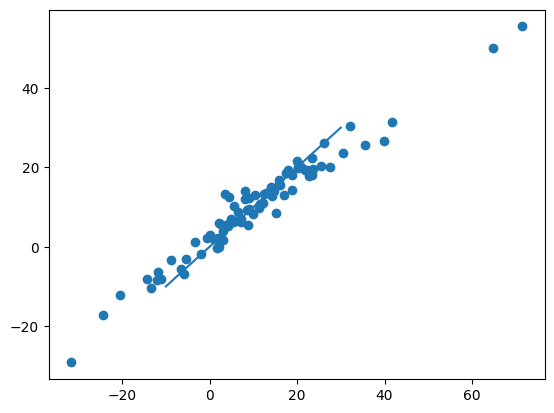

In [109]:
plt.scatter(y_test, y_pred, marker='o')
#plt.scatter(y_train, clf.predict(X_train), marker='o')

plt.plot([-10, 30], [-10, 30])

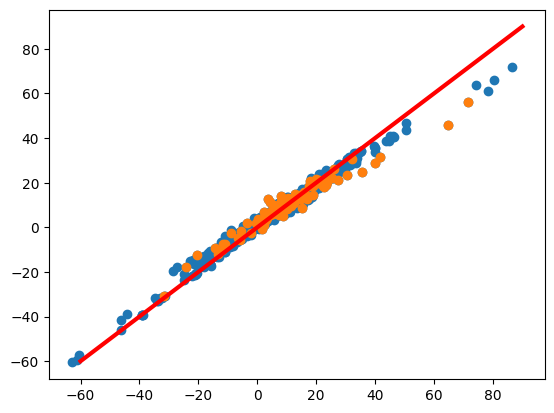

In [117]:
plt.scatter(y, clf.predict(vector), marker='o')
plt.scatter(y_test, clf.predict(X_test), marker='o')

#plt.scatter(y_train, clf.predict(X_train), marker='o')

plt.plot([-60, 90], [-60, 90], c='red', lw=3)

(array([  1.,   1.,   0.,   0.,   2.,   1.,   3.,   3.,   2.,   4.,   4.,
          3.,  11.,  14.,  28.,  33.,  44.,  62., 109., 181., 121.,  70.,
         37.,  22.,  17.,  11.,  15.,   4.,   5.,   2.,   1.,   2.,   4.,
          1.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   2.,
          0.,   1.,   1.,   0.,   1.,   1.]),
 array([-10.56740016, -10.02355886,  -9.47971755,  -8.93587625,
         -8.39203495,  -7.84819365,  -7.30435234,  -6.76051104,
         -6.21666974,  -5.67282844,  -5.12898713,  -4.58514583,
         -4.04130453,  -3.49746322,  -2.95362192,  -2.40978062,
         -1.86593932,  -1.32209801,  -0.77825671,  -0.23441541,
          0.30942589,   0.8532672 ,   1.3971085 ,   1.9409498 ,
          2.4847911 ,   3.02863241,   3.57247371,   4.11631501,
          4.66015632,   5.20399762,   5.74783892,   6.29168022,
          6.83552153,   7.37936283,   7.92320413,   8.46704543,
          9.01088674,   9.55472804,  10.09856934,  10.64241065,
         11.186251

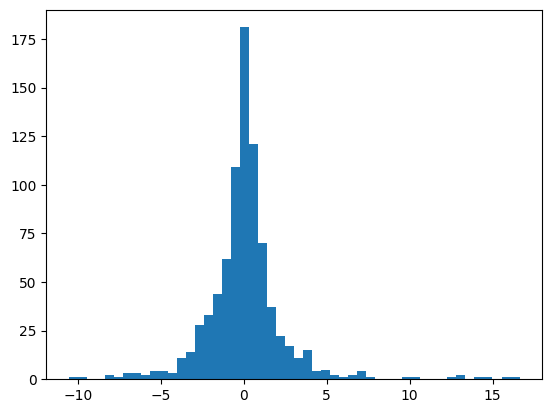

In [111]:
plt.hist(y-clf.predict(vector), bins=50)

In [112]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score    

def objective(trial):
    # Define the hyperparameters to be tuned
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)

    MF = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    
    
    
    # Initialize the model with the suggested hyperparameters
    model = RandomForestRegressor(n_estimators=n_estimators, 
                                   max_depth=max_depth, 
                                   max_features=MF,
                                   min_samples_split=min_samples_split)

    # Evaluate the model using cross-validation
    #score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
    return score

# Create the study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best parameters
settings = study.best_params

[I 2024-10-17 14:47:51,544] A new study created in memory with name: no-name-4031ac70-2d10-4a53-98fb-a329e3f03e2f
[I 2024-10-17 14:47:52,044] Trial 0 finished with value: 0.7931307746249817 and parameters: {'n_estimators': 151, 'max_depth': 20, 'min_samples_split': 12, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7931307746249817.
[I 2024-10-17 14:47:52,869] Trial 1 finished with value: 0.7880149425292557 and parameters: {'n_estimators': 262, 'max_depth': 23, 'min_samples_split': 20, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7931307746249817.
[I 2024-10-17 14:47:53,403] Trial 2 finished with value: 0.8584129076402732 and parameters: {'n_estimators': 114, 'max_depth': 50, 'min_samples_split': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.8584129076402732.
[I 2024-10-17 14:47:54,040] Trial 3 finished with value: 0.8210721033607763 and parameters: {'n_estimators': 192, 'max_depth': 33, 'min_samples_split': 14, 'max_features': 'sqrt'}. Best is trial 2 wit

[I 2024-10-17 14:48:11,392] Trial 36 finished with value: 0.8533992423957001 and parameters: {'n_estimators': 137, 'max_depth': 29, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8623751598166368.
[I 2024-10-17 14:48:11,804] Trial 37 finished with value: 0.8379779954871038 and parameters: {'n_estimators': 109, 'max_depth': 35, 'min_samples_split': 3, 'max_features': 'log2'}. Best is trial 28 with value: 0.8623751598166368.
[I 2024-10-17 14:48:12,322] Trial 38 finished with value: 0.8319297691978857 and parameters: {'n_estimators': 153, 'max_depth': 41, 'min_samples_split': 12, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8623751598166368.
[I 2024-10-17 14:48:12,881] Trial 39 finished with value: 0.7162307284389039 and parameters: {'n_estimators': 192, 'max_depth': 48, 'min_samples_split': 34, 'max_features': 'log2'}. Best is trial 28 with value: 0.8623751598166368.
[I 2024-10-17 14:48:13,247] Trial 40 finished with value: 0.7393644910142341 a

In [113]:
#settings={'n_estimators': 256, 'max_depth': 46, 'min_samples_split': 2, 'max_features': 'sqrt'}
clf = RandomForestRegressor(**settings)
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=34, max_features='sqrt', n_estimators=246)

In [114]:
from sklearn.metrics import r2_score, mean_absolute_error
y_pred = clf.predict(X_train)

def objective(trial):
    # Define the hyperparameters to be tuned
    a = trial.suggest_float('a', -4, 4)
    #b = trial.suggest_float('b', -2, 2)

    def correction(x, a, b=0):
        return a*x+b
    
    y_corrected = correction(y_pred, a)
    
    score = mean_absolute_error(y_train, y_corrected)+(1-r2_score(y_train, y_corrected))
    return score

# Create the study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Best parameters
params = study.best_params
params.update({'b':0})

[I 2024-10-17 14:48:19,044] A new study created in memory with name: no-name-f46d9a53-d30a-479e-95fd-5a1c2706a35f
[I 2024-10-17 14:48:19,045] Trial 0 finished with value: 2.4812760572811148 and parameters: {'a': 0.9084935209913123}. Best is trial 0 with value: 2.4812760572811148.
[I 2024-10-17 14:48:19,046] Trial 1 finished with value: 8.020834178087123 and parameters: {'a': 0.4960201762306209}. Best is trial 0 with value: 2.4812760572811148.
[I 2024-10-17 14:48:19,047] Trial 2 finished with value: 64.56774948014441 and parameters: {'a': -2.6563790466608097}. Best is trial 0 with value: 2.4812760572811148.
[I 2024-10-17 14:48:19,048] Trial 3 finished with value: 19.733738862522536 and parameters: {'a': -0.2736333825333235}. Best is trial 0 with value: 2.4812760572811148.
[I 2024-10-17 14:48:19,049] Trial 4 finished with value: 24.735518071929896 and parameters: {'a': -0.5771563761897607}. Best is trial 0 with value: 2.4812760572811148.
[I 2024-10-17 14:48:19,050] Trial 5 finished with 

[I 2024-10-17 14:48:19,173] Trial 49 finished with value: 8.484045706105537 and parameters: {'a': 0.4636762966548831}. Best is trial 31 with value: 1.3635640969171565.
[I 2024-10-17 14:48:19,176] Trial 50 finished with value: 2.6701044886056824 and parameters: {'a': 0.892823964633395}. Best is trial 31 with value: 1.3635640969171565.
[I 2024-10-17 14:48:19,179] Trial 51 finished with value: 1.3852617757406325 and parameters: {'a': 1.0646084749421194}. Best is trial 31 with value: 1.3635640969171565.
[I 2024-10-17 14:48:19,182] Trial 52 finished with value: 5.923610206911861 and parameters: {'a': 1.4853107424560512}. Best is trial 31 with value: 1.3635640969171565.
[I 2024-10-17 14:48:19,186] Trial 53 finished with value: 20.784059337452515 and parameters: {'a': -0.3384265250603221}. Best is trial 31 with value: 1.3635640969171565.
[I 2024-10-17 14:48:19,189] Trial 54 finished with value: 15.336060937313004 and parameters: {'a': 2.1310516680356493}. Best is trial 31 with value: 1.363564

[I 2024-10-17 14:48:19,339] Trial 98 finished with value: 5.169021619255607 and parameters: {'a': 0.7002479126680243}. Best is trial 31 with value: 1.3635640969171565.
[I 2024-10-17 14:48:19,342] Trial 99 finished with value: 10.7306033436422 and parameters: {'a': 1.8250256471884192}. Best is trial 31 with value: 1.3635640969171565.


1.6637587450743097
1.5178479445920612
0.97245623742763
0.9778291467395478
---
0.9285951091316653
3.046763222409842


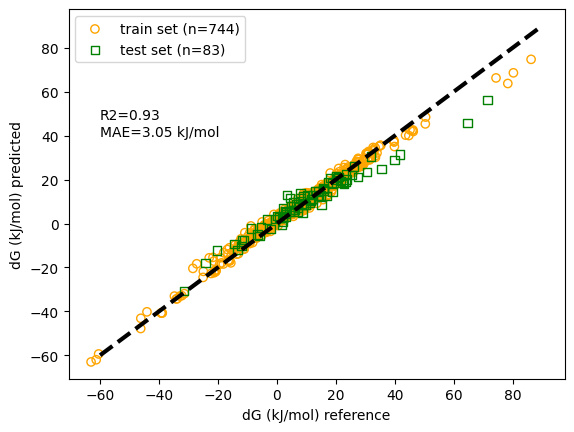

In [130]:
#params={'a': 1.134997891196554, 'b': -1.6173264505748035}

def correction(x, a, b):
        return a*x+b

print(mean_absolute_error(y, clf.predict(vector)))    
print(mean_absolute_error(y,correction(clf.predict(vector), **params)))    

print(r2_score(y, clf.predict(vector)))
print(r2_score(y, correction(clf.predict(vector), **params)))

print("---")
print(r2_score(y_test, correction(clf.predict(X_test), **params)))
print(mean_absolute_error(y_test,correction(clf.predict(X_test), **params)))    


#plt.scatter(y, clf.predict(vector), marker='o')
ntrain = X_train.shape[0]
plt.scatter(y_train, correction(clf.predict(X_train),  **params), marker='o', facecolors='none', edgecolors='orange', label=f"train set (n={ntrain})")

ntest = X_test.shape[0]
plt.scatter(y_test, clf.predict(X_test), marker='s',facecolors='none', edgecolors='green', label=f"test set (n={ntest})")

#plt.plot([-20, 40], [-20, 40], c='red', lw=3)

plt.plot([-60, 90], [-60, 90], c='black', ls='--', lw=3)
#plt.plot([-60, 90], [-50, 100], c='red', lw=3, ls='--')
#plt.plot([-60, 90], [-70, 80], c='red', lw=3, ls='--')
plt.text(-60, 40, s='R2=0.93\nMAE=3.05 kJ/mol')
plt.xlabel('dG (kJ/mol) reference')
plt.ylabel('dG (kJ/mol) predicted')
plt.legend()
plt.savefig('RF_results.png', dpi=300)

3.19436044856063
3.046763222409842
0.9175387204478989
0.9285951091316653


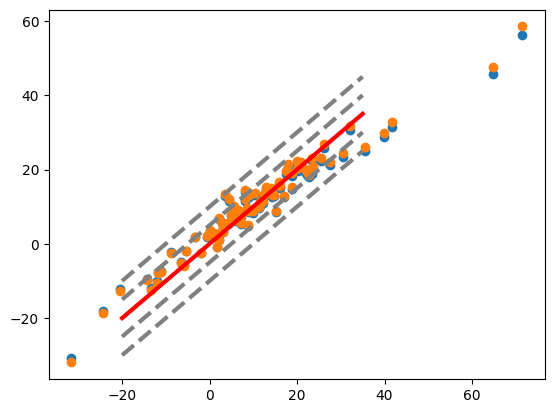

In [116]:
#params={'a': 1.2118146926510727, 'b': -2.6328637776814654}

def correction(x, a, b):
        return a*x+b

print(mean_absolute_error(y_test, clf.predict(X_test)))    
print(mean_absolute_error(y_test, correction(clf.predict(X_test), **params)))    

print(r2_score(y_test, clf.predict(X_test)))
print(r2_score(y_test, correction(clf.predict(X_test), **params)))

#plt.scatter(y, clf.predict(vector), marker='o')
#plt.scatter(y, correction(clf.predict(vector),  **params), marker='o')
#plt.scatter(y_test, clf.predict(X_test), marker='o')
plt.scatter(y_test, clf.predict(X_test), marker='o')
plt.scatter(y_test, correction(clf.predict(X_test), **params), marker='o')

y_pred = clf.predict(vector)

#plt.plot(y[idxs], y_pred[idxs], marker='^')

plt.plot([-20, 35], [-20, 35], c='red', lw=3)
plt.plot([-20, 35], [-10, 45], c='gray', lw=3, ls='--')
plt.plot([-20, 35], [-30, 25], c='gray', lw=3, ls='--')
plt.plot([-20, 35], [-15, 40], c='gray', lw=3, ls='--')
plt.plot([-20, 35], [-25, 30], c='gray', lw=3, ls='--')

In [40]:
diff = np.abs(y-correction(clf.predict(vector),**params))
idxs = np.where(diff >5)
mols[idxs[0]]

array([['ethanol', '{[#SP1]}.{#SP1=CCO}', '{[#C1]|4}'],
       ['acetamide', '{[#SP5]}.{#SP5=CC(N)=O}', '{[#C1]|4}'],
       ['formamide', '{[#SP6r]}.{#SP6r=NC=O}', '{[#C1]|4}'],
       ['DCE', '{[#X4h]}.{#X4h=ClCCCl}', '{[#C1]|4}'],
       ['glycine', '{[#P6]}.{#P6=NCC(O)=O}', '{[#C1]|4}'],
       ['DISS', '{[#TC3][#SC5][#TC3]}.{#TC3=CC[!]C,#SC5=[!]CSC[!]}',
        '{[#X2]}'],
       ['DMSO', '{[#SC6][#TP6]}.{#SC6=CS[!]C,#TP6=[!]S=O}', '{[#C1]|4}'],
       ['PTI', '{[#SC2][#SN6d]}.{#SC2=CCC[$],#SN6d=[$]CCN}', '{[#X2]}'],
       ['DOE', '{[#C4][#C1]|2}.{#C4=C=CCC[$],#C1=[$]CCCC[$]}',
        '{[#C1]|4}'],
       ['cyanamide', '{[#P4d]}.{#P4d=NC#N}', '{[#C1]|4}'],
       ['MAMD', '{[#SC3][#TP6a]}.{#SC3=CC(C)[$],#TP6a=[$]C(=O)N}',
        '{[#X2]}'],
       ['MAMD', '{[#SC3][#TP6a]}.{#SC3=CC(C)[$],#TP6a=[$]C(=O)N}',
        '{[#C1]|4}'],
       ['R29', '{[#TC4][#SN4a]}.{#TC4=C=C[$],#SN4a=[$]C(=O)OC}',
        '{[#SC2][#SC2][#SP2]}'],
       ['3HT',
        '{[#SC2][#SC2][#TC5]1[#TC5][#T

(array([ 1.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  4.,  7.,  4.,  5.,
         7.,  8., 15., 24., 20., 13.,  4.,  3.,  3.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  1.]),
 array([-61.32      , -56.89266667, -52.46533333, -48.038     ,
        -43.61066667, -39.18333333, -34.756     , -30.32866667,
        -25.90133333, -21.474     , -17.04666667, -12.61933333,
         -8.192     ,  -3.76466667,   0.66266667,   5.09      ,
          9.51733333,  13.94466667,  18.372     ,  22.79933333,
         27.22666667,  31.654     ,  36.08133333,  40.50866667,
         44.936     ,  49.36333333,  53.79066667,  58.218     ,
         62.64533333,  67.07266667,  71.5       ]),
 <BarContainer object of 30 artists>)

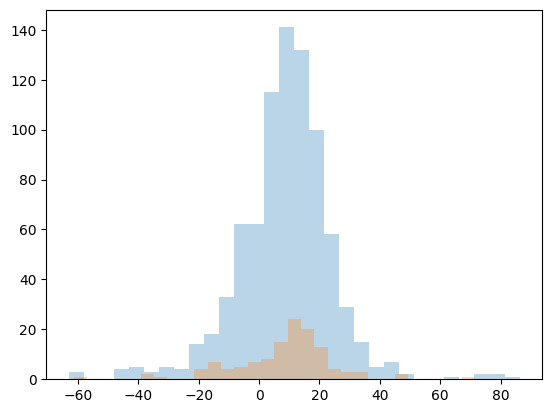

In [41]:
plt.hist(y, bins=30,alpha=0.3)
plt.hist(y_test, bins=30, alpha=0.3)

In [ ]:
level_matrix, bead_to_index = read_inter_matrix('../SolubilityML/levels.dat')
#mol_name,mol_tag,smiles_str,cgsmiles_str,OCO,HD,CLF
m3_df = pd.read_excel('../CGSmiles_benchmark/MartiniCGSmilesDB_v5.xls', sheet_name='ExtensionI')
mol_strings = read_mol_strings() 
vector = np.zeros((1, 229))
y = np.zeros(39, dtype=float)
idx = 0
mols = []
feature_list = []
counter = 0
for cgsmiles_str, OCO in zip(m3_df.get('CGSmiles'), m3_df.get('dG')):
    oco="{[#SC2][#SC2][#SP2]}"
    hd="{[#C1]|4}"
    #clf="{[#X2]}"
    cgmol = cgsmiles_str #.split('.')[0]
    for mol_str_b, logp in zip([oco], [OCO]):
        if np.isnan(logp):
            continue
        try:
            new_vector, bead_to_index = generate_feature_vector(cgmol, 
                                                                mol_str_b, 
                                                                level_matrix, 
                                                                bead_to_index, 
                                                                polyB=False)
        except:
            continue
        
        #new_vector, bead_to_index = generate_feature_vector_old(cgmol, 
        #                                                        mol_str_b, 
        #                                                        level_matrix, 
        #                                                        bead_to_index, 
        #polyB=False)
        for jdx, other in enumerate(feature_list):
            if np.all(new_vector.nonzero()[0] == other):
               # print(vector[jdx+1].nonzero())
                #print(new_vector.nonzero())
                #print("--")
                if np.all(vector[jdx+1][:-1] == new_vector[:-1]):
                    duplicate = True
                    #if logp != y[jdx]:
                   #     print(logp, y[jdx], cgmol)
                    counter +=1
                    break
        else:
            duplicate = False
            
        if duplicate:
            continue
        
        feature_list.append(new_vector.nonzero()[0])
        vector = np.vstack([vector, new_vector])
        y[idx] = float(logp)
        idx +=1
        mols.append((cgsmiles_str, mol_str_b))
    #if idx > 10:
    #    break
mols = np.array(mols)
vector = vector[1:]
vector = vector.astype(int)
print(counter)

In [ ]:
vector.shape

In [ ]:
y.shape

In [ ]:
plt.scatter(y, clf.predict(vector), marker='o')
plt.scatter(y, correction(clf.predict(vector), **params), marker='o')

plt.plot([-10, 40], [-10, 40], c='red', lw=3)

In [ ]:
print(mean_absolute_error(y, clf.predict(vector)))    
print(mean_absolute_error(y, correction(clf.predict(vector), **params)))    

print(r2_score(y, clf.predict(vector)))
print(r2_score(y, correction(clf.predict(vector), **params)))

In [ ]:
m3_df = pd.read_excel('../CGSmiles_benchmark/MartiniCGSmilesDB_v5.xls', sheet_name='All')
volumes = []
mol_sizes = []
atoms = []
prev=0
aromatic = 0
other = 0
deg_aa = []
deg_cg = []
for mol_tag, cgsmiles_str in zip(m3_df.get('MOLTAG'), m3_df.get('CGSmiles')):
    mol_a, aa_mol = cgsmiles.MoleculeResolver.from_string(cgsmiles_str).resolve_all()
    smiles_str = pysmiles.write_smiles(aa_mol)
    if any(list(nx.get_node_attributes(aa_mol, 'aromatic').values())):
        aromatic += 1
    else:
        other += 1
    
    deg_aa += list(dict(aa_mol.degree).values())
    deg_cg += list(dict(mol_a.degree).values())
    
    
    mol = Chem.AddHs(Chem.MolFromSmiles(smiles_str))
    AllChem.EmbedMolecule(mol)
    vol = AllChem.ComputeMolVolume(mol)
    volumes.append(vol)
    mol_sizes.append(len(mol_a))
    atoms.append(len(aa_mol))
    if len(aa_mol) > prev:
        largest=mol_tag

In [ ]:
aromatic

In [ ]:
aa_mol.degree

In [ ]:
plt.hist(mol_sizes,bins=8)

In [ ]:
plt.hist(atoms,bins=30)

In [ ]:
plt.hist(volumes)

In [ ]:
plt.violinplot(mol_sizes)

In [ ]:
plt.hist(deg_cg, bins=4)

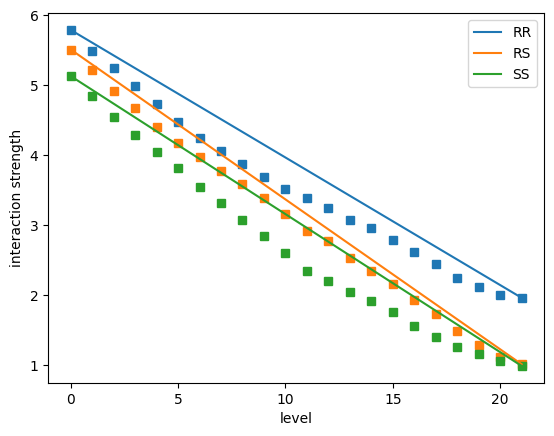

In [149]:
rr_levels=[5.790, 5.490,5.240,4.990,4.730,4.480,4.250,4.060,3.880,3.690,3.520,3.390,3.240,3.070,2.960,2.790,2.620,
2.440,2.240,2.12,2.000,1.960]
rs_levels=[5.510,5.210,4.920,4.680,4.400,4.170,3.970,3.770,3.590,3.380,3.160,2.920,2.770,2.530,2.340,2.160,1.930,1.730,
          1.480, 1.280,1.118,1.010]
ss_levels=[5.130,4.840,4.550,4.290,4.040,3.820,3.550,3.310,3.070,2.840,2.600,2.350,2.200,2.040,1.910,1.750,1.560,1.400,1.250
    ,1.150,1.050,0.986]

plt.plot(rr_levels, marker='s', ls='')
plt.plot(rs_levels, marker='s', ls='')
plt.plot(ss_levels, marker='s', ls='')

plt.plot([0, 21], [5.79, 1.960],c='tab:blue', label='RR')
plt.plot([0, 21], [max(rs_levels), min(rs_levels)],c='tab:orange', label='RS')
plt.plot([0, 21], [max(ss_levels), min(ss_levels)],c='tab:green', label='SS')
plt.legend()
plt.xlabel('level')
plt.ylabel('interaction strength')
plt.savefig('levels.png', dpi=300)

In [ ]:
ss=[5.130,4.840,4.550,4.290,4.040,3.820,3.550,3.310,3.070,2.840,2.600,2.350,2.200,2.040,1.910,1.750,1.560,1.400,1.250
    ,1.150,1.050,0.986]